In [87]:
#basic python imports
import numpy as np
import pickle
import time as tm
import qetpy as qp


#plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.figsize'] = [10, 6.5]

#fft stuff
from scipy.fftpack import fft, ifft, fftfreq

#various QETpy functions
from qetpy.core.didv._uncertainties_didv import get_dPdI_with_uncertainties
from qetpy.core.didv._templates_didv import _p_delta_frequency, _p_pulse_frequency, get_didv_template, get_phonon_template
from qetpy.core.didv._templates_didv import get_simple_energy_normalization, get_energy_normalization
from qetpy.utils import make_template_twopole, make_template_threepole
from qetpy.core.didv._uncertainties_didv import get_power_noise_with_uncertainties, get_dPdI_with_uncertainties
from qetpy import Noise
from qetpy.sim import TESnoise
from qetpy.plotting import compare_noise, plot_noise_sim

from detprocess import Template
from detprocess import Noise

#for reading in data
from pytesdaq.io.hdf5 import H5Reader
from glob import glob
from scipy.fftpack import fft, ifft, fftfreq

from pytesdaq.io.hdf5 import H5Reader
from pytesdaq.processing import process_ivsweep, IVanalysis
from pytesdaq.processing import _iv_didv_tools_plotting as plot


rsh = 5e-3
fs = 1.25e6

In [88]:
import h5py as h5
test_file = '/sdata1/runs/run20/raw/iv_didv_I2_D20220914_T210929/didv_I2_D20220914_T232615_F0001.hdf5'
file = h5.File( test_file, 'r' )
print( file.keys() )
print( file['adc1'].attrs.keys())

print(file['adc1'].attrs['connection2'])
print(file['detconfig1'].attrs.keys())
print(file['detconfig1'].attrs['tes_bias'])

<KeysViewHDF5 ['adc1', 'detconfig1']>
<KeysViewHDF5 ['adc_channel_indices', 'adc_conversion_factor', 'connection2', 'data_mode', 'nb_channels', 'nb_events', 'nb_samples', 'sample_rate', 'trig_channel', 'voltage_range']>
['detector:IrPtTESBig' 'tes:C' 'controller:feb1_C']
<KeysViewHDF5 ['adc_channel_indices', 'adc_conversion_factor', 'adc_name', 'channel_list', 'channel_type', 'close_loop_norm', 'feedback_mode', 'feedback_polarity', 'feedback_resistance', 'lock_point_voltage', 'open_loop_full_norm', 'open_loop_preamp_norm', 'output_gain', 'output_offset', 'preamp_gain', 'shunt_resistance', 'signal_gen_current', 'signal_gen_frequency', 'signal_gen_onoff', 'signal_gen_phase_shift', 'signal_gen_shape', 'signal_gen_source', 'signal_gen_tes_resistance', 'signal_gen_voltage', 'signal_source', 'squid_bias', 'squid_turn_ratio', 'tes_bias']>
0.00020989012


In [89]:
#this is the folder or file where data is located
path =   '/sdata1/runs/run20/raw/iv_didv_I2_D20220914_T210929/didv_I2_D20220914_T232615_F0001.hdf5'# big tes # '/sdata1/runs/run20/raw/iv_didv_I2_D20220914_T180121/didv_I2_D20220914_T194128_F0001.hdf5' #Small TES  #'/sdata1/runs/run20/raw/iv_didv_I2_D20220914_T180121/didv_I2_D20220914_T193548_F0001.hdf5' Small TES 70uA #'/sdata1/runs/run20/raw/iv_didv_I2_D20220914_T210929/didv_I2_D20220914_T230343_F0001.hdf5' Big TES 250uA

#these are the channel(s) we want to analyze. For dIdVs, this should just be a single channel of data
chans = ['IrPtTESBig']#IrPtTESSmall

h5read = H5Reader()
traces_temp, metadata = h5read.read_many_events(
    filepath = path,
    nevents=-1, #this tells read_many_events to read all the events in the file
    output_format=2,
    detector_chans=chans,
    include_metadata=True, #we want the metadata to look at e.g. the device bias current
    adctoamp = True
)

In [90]:
traces = []
i = 10 #there can sometimes be data quality issues with the first few events in dIdVs
       #so we skip the first 10 events
while i < len(traces_temp):
    traces.append(traces_temp[i][0])
    i += 1

traces = np.asarray(traces)

#this line does autocuts on the traces and reduces traces to only good events
#can be commented out if it's being slow and the data is known to be high quality
traces = np.asarray(traces)[qp.autocuts_didv(np.asarray(traces))]

In [91]:
#these parameters are loaded into the dIdV to make the smallsignalparameters correct
#later, these parameters are essentially refit from understanding the true current
#through the TES. However, we need to run the dIdV fit once first to get the dIdV
#offset fit.
rp = 0.003 #ohms, parasitic resistance
r0 = 0.182 #ohms, TES resistance at bias point
rsh = 5e-3 #ohms, shunt resistance, the standard Pyle group value
fs = int(1.25e6) #Hz, sampling frequency
sgfreq = float(metadata[0]['detector_config'][chans[0]]['signal_gen_frequency']) #the signal generator frequency
                                                                                 #read in directly from metadata
sgamp = float(metadata[0]['detector_config'][chans[0]]['signal_gen_current']) #the signal generator amplitude
                                                                              #read in directly from metadata


didvfit = qp.DIDV(
    traces,
    fs,
    sgfreq,
    sgamp,
    rsh,
    tracegain=1.0,
    r0=r0, # the expected r0 should be specified if the estimated small-signal parameters are desired (otherwise they will be nonsensical)
    rp=rp, # the expected rp should be specified if the estimated small-signal parameters are desired (otherwise they will be nonsensical)
    dt0=-1e-6, # a good estimate of the time shift value will likely speed up the fit/improve accuracy
    add180phase=False, # if the fits aren't working, set this to True to see if the square wave is off by half a period
)

In [92]:
didvfit.dofit(2)
print("Done with Two Pole Fit")
didvfit.dofit(3)
print("Done with Three Pole Fit")

Done with Two Pole Fit
Done with Three Pole Fit


In [93]:
result2 = didvfit.fitresult(2) 
result3 = didvfit.fitresult(3) 

In [94]:
print("Fit time constants, NOT dIdV Poles: ")
print("Tau1: " + str(np.abs(result3['params']['tau1'])) + ' s')
print("Tau2: " + str(result3['params']['tau2']) + ' s')
print("Tau3: " + str(result3['params']['tau3']) + ' s')
print(" ")

print("True dIdV Poles: ")
print("Tau_plus: " + str(result3['falltimes'][0]) + ' s')
print("Tau_minus: " + str(result3['falltimes'][1]) + ' s')
print("Tau_third: " + str(result3['falltimes'][2]) + ' s')

Fit time constants, NOT dIdV Poles: 
Tau1: 6.791957089511856e-05 s
Tau2: 2.3419501600033494e-06 s
Tau3: 3.6967785915789316e-05 s
 
True dIdV Poles: 
Tau_plus: 3.0005761843613287e-06 s
Tau_minus: 1.0538680932223699e-05 s
Tau_third: 8.957370494290395e-05 s


In [9]:
IV_dIdV_sweep_folder = '/sdata1/runs/run20/raw/iv_didv_I2_D20220914_T180121'
chans = ['IrPtTESSmall']
channel_num = 0

In [10]:
# create an object of the H5Reader class 
h5read = H5Reader() 

# get the start time so we know the total time 
start_time = tm.time()

# get the dataframe for the processed raw data
df = []
df = process_ivsweep(
    ivfilepath=IV_dIdV_sweep_folder,
    chans=chans,
    lgcverbose=True, # Switch to True to know which file its on
    lgcsave=False,
)
# get the end time 
end_time = tm.time()

print(f'IV sweep took {(end_time - start_time)/60: .3f} min to process')

#need to flip the QET bias for all the Pyle lab data
df.qetbias*= -1 

#convert the dataframe into a IV object that we can work with
IVobj = IVanalysis(
    df, 
    rshunt = 5e-3,
    nnorm=5, # number of points in normal region
    nsc=5, # number of points in superconducting region
    lgcremove_badseries = False
)

IVobj.rshunt_err = 0.1e-3


Processing dumps in: /sdata1/runs/run20/raw/iv_didv_I2_D20220914_T180121/didv_I2_D20220914_T180303_F0001.hdf5

Processing channel IrPtTESSmall (ndarray index = 0)
----
dIdV processing
----

Processing dumps in: /sdata1/runs/run20/raw/iv_didv_I2_D20220914_T180121/didv_I2_D20220914_T180551_F0001.hdf5

Processing channel IrPtTESSmall (ndarray index = 0)
----
dIdV processing
----

Processing dumps in: /sdata1/runs/run20/raw/iv_didv_I2_D20220914_T180121/didv_I2_D20220914_T180839_F0001.hdf5

Processing channel IrPtTESSmall (ndarray index = 0)
----
dIdV processing
----

Processing dumps in: /sdata1/runs/run20/raw/iv_didv_I2_D20220914_T180121/didv_I2_D20220914_T181127_F0001.hdf5

Processing channel IrPtTESSmall (ndarray index = 0)
----
dIdV processing
----

Processing dumps in: /sdata1/runs/run20/raw/iv_didv_I2_D20220914_T180121/didv_I2_D20220914_T181414_F0001.hdf5

Processing channel IrPtTESSmall (ndarray index = 0)
----
dIdV processing
----


In [ ]:
#make a few plots to ensure all is well
IVobj.analyze_sweep(lgcplot = True)

In [ ]:
#read in 2 events to get the metadata
didvfilepath = sorted(glob(IV_dIdV_sweep_folder + '/didv_*'))[0]
traces_temp, metadata = h5read.read_many_events(filepath = didvfilepath,
    nevents=2,
    output_format=2,
    detector_chans=chans,
    include_metadata=True,
    adctoamp = True
)

#generate the offset dictionary
offset_dict = IVobj.get_offsets_dict(metadata, chans[0])

print(offset_dict)

In [ ]:
#save the offset dictionary
#rq_files_path = '/sdata1/runs/run20/processed/'
#save_dict_name = 'offsets_' + str(chans[channel_num]) + "_"
#print("Save as: " + save_dict_name)

#with open(rq_files_path + save_dict_name, 'wb') as handle:
#    pickle.dump(offset_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [95]:
save_dict_name = 'offsets_IrPtTESBig_'
rq_files_path = '/sdata1/runs/run20/processed/'

with open(rq_files_path + save_dict_name, 'rb') as handle:
    offsets_dict = pickle.load(handle)

print(offsets_dict)

{'i0_off': 1.6154168098757138e-05, 'i0_off_err': 7.446290281880087e-10, 'ibias_off': -1.7759463259490532e-07, 'ibias_off_err': 1.4209288314461689e-09, 'i0_changable_offset': 4.0537242e-07, 'rp': 0.004529920894121458, 'IVobj': <pytesdaq.processing._iv_didv_tools.IVanalysis object at 0x7f55b40a2048>}


In [96]:
channel_name = 'IrPtTESBig'

#gets information from the metadata loaded in when we loaded in traces to understand the offsets on the dIdV
output_offset = float(metadata[0]['detector_config'][channel_name]['output_offset'])
closed_loop_norm = float(metadata[0]['detector_config'][channel_name]['close_loop_norm'])
ibias_metadata = float(metadata[0]['detector_config'][channel_name]['tes_bias'])

In [97]:
didvfit.dofit_with_true_current(offsets_dict, output_offset, closed_loop_norm, ibias_metadata)
result = didvfit.fitresult(3) #this is the actual object we inspect when we want to know information
                                         #about the dIdV fit

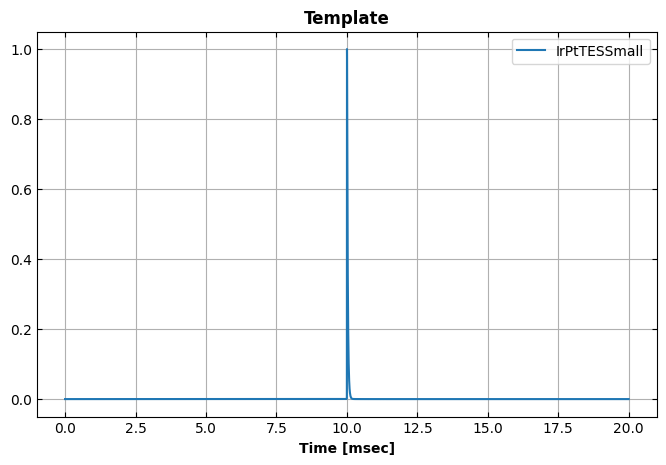

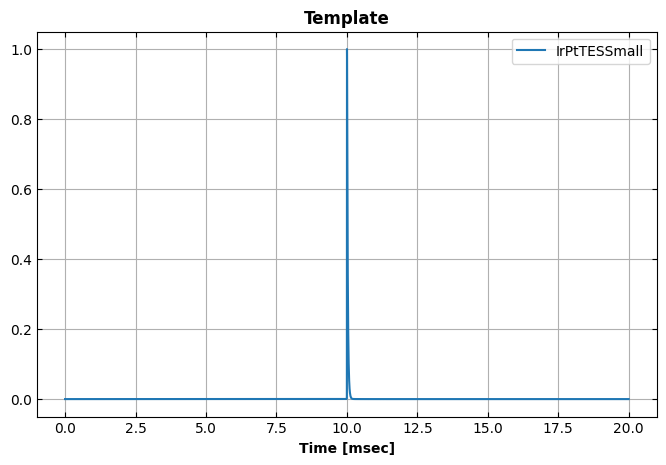

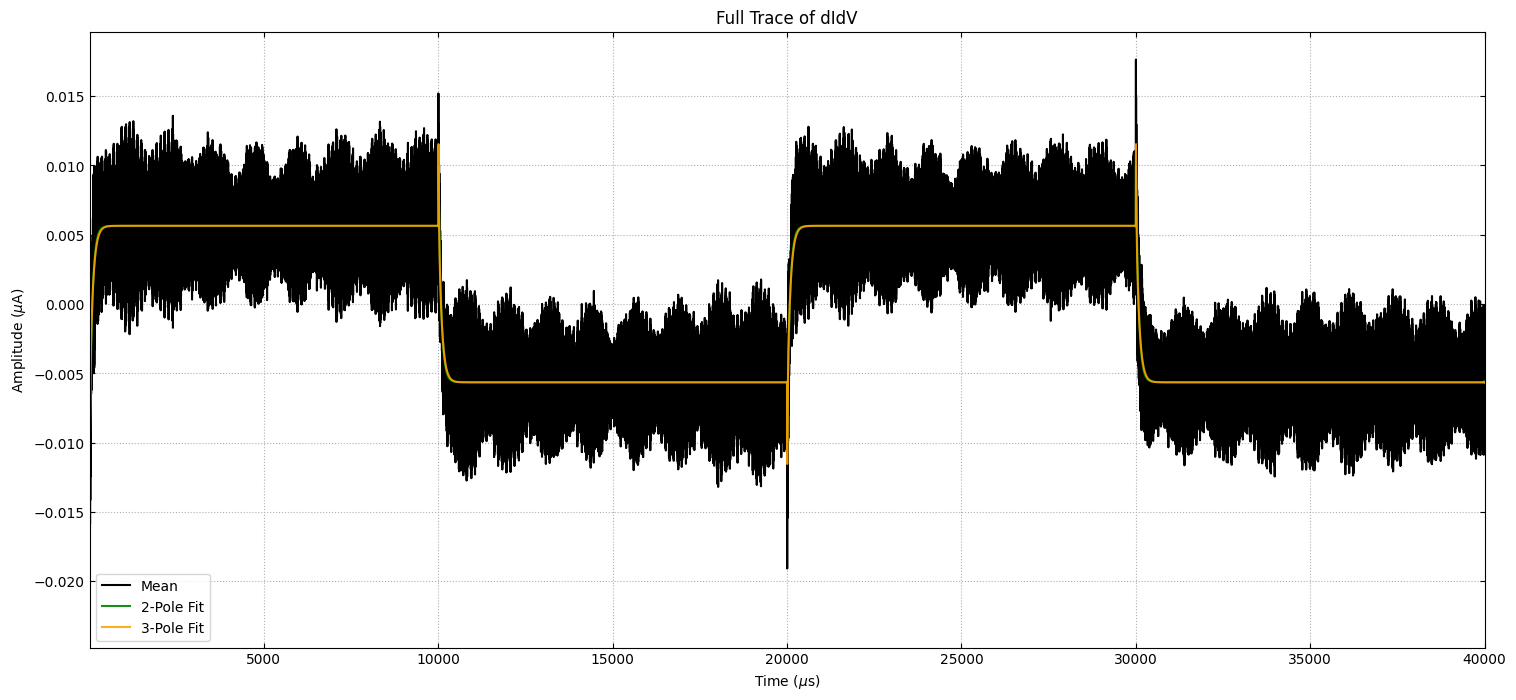

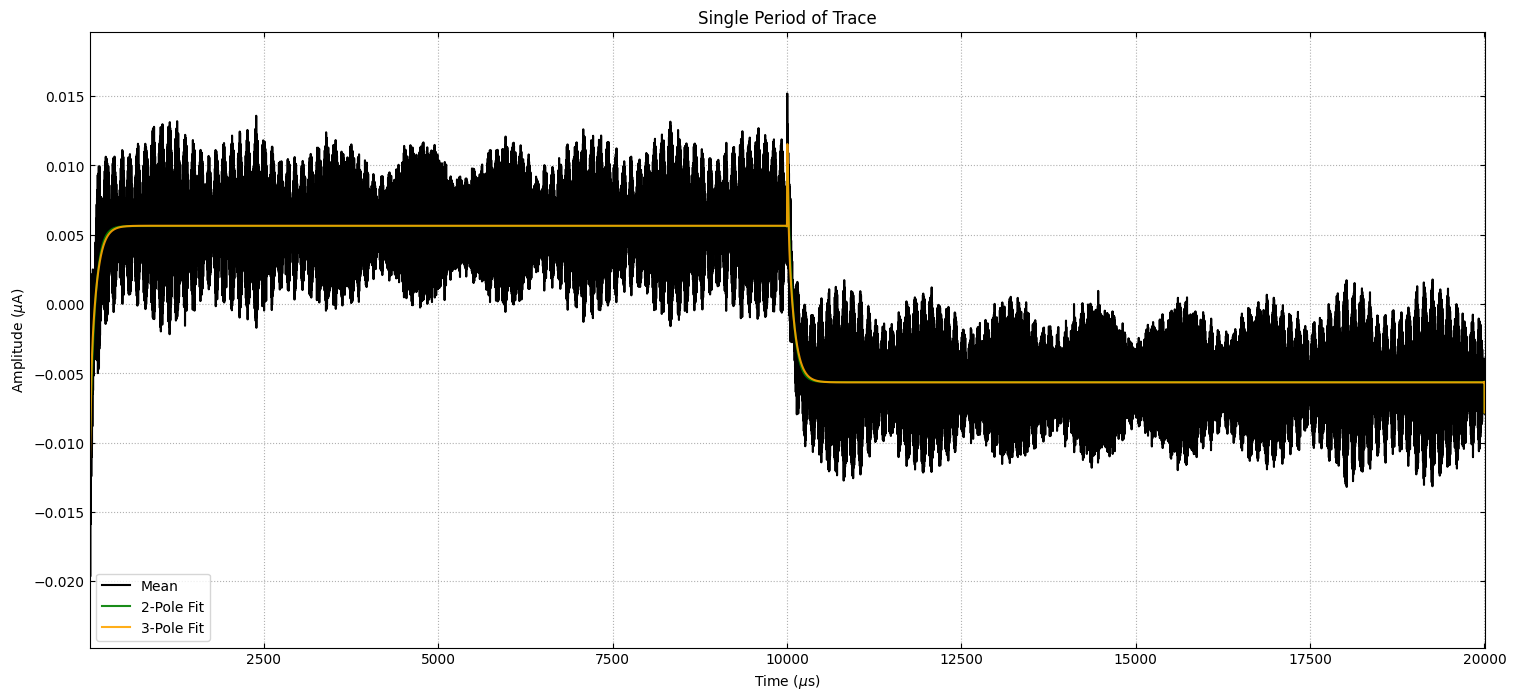

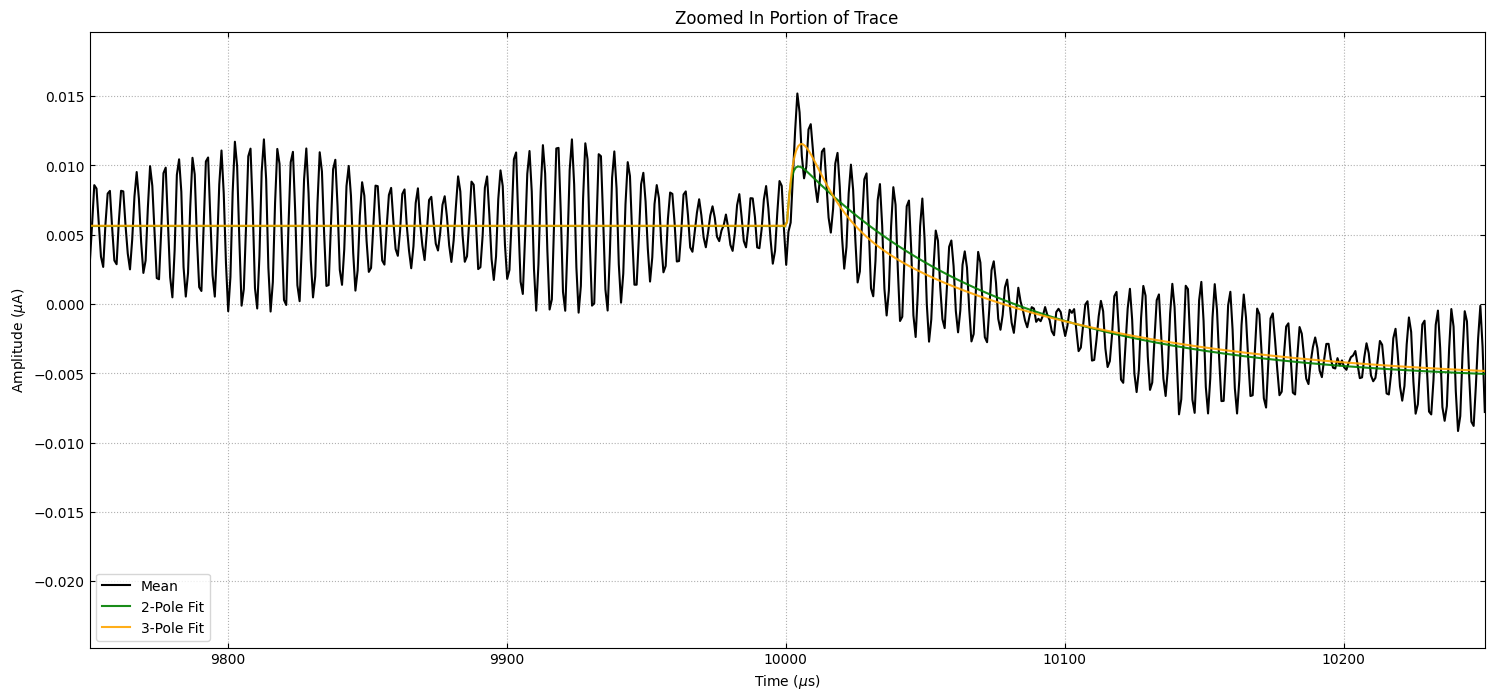

In [98]:
didvfit.plot_full_trace()
didvfit.plot_single_period_of_trace()
didvfit.plot_zoomed_in_trace(zoomfactor=0.025)

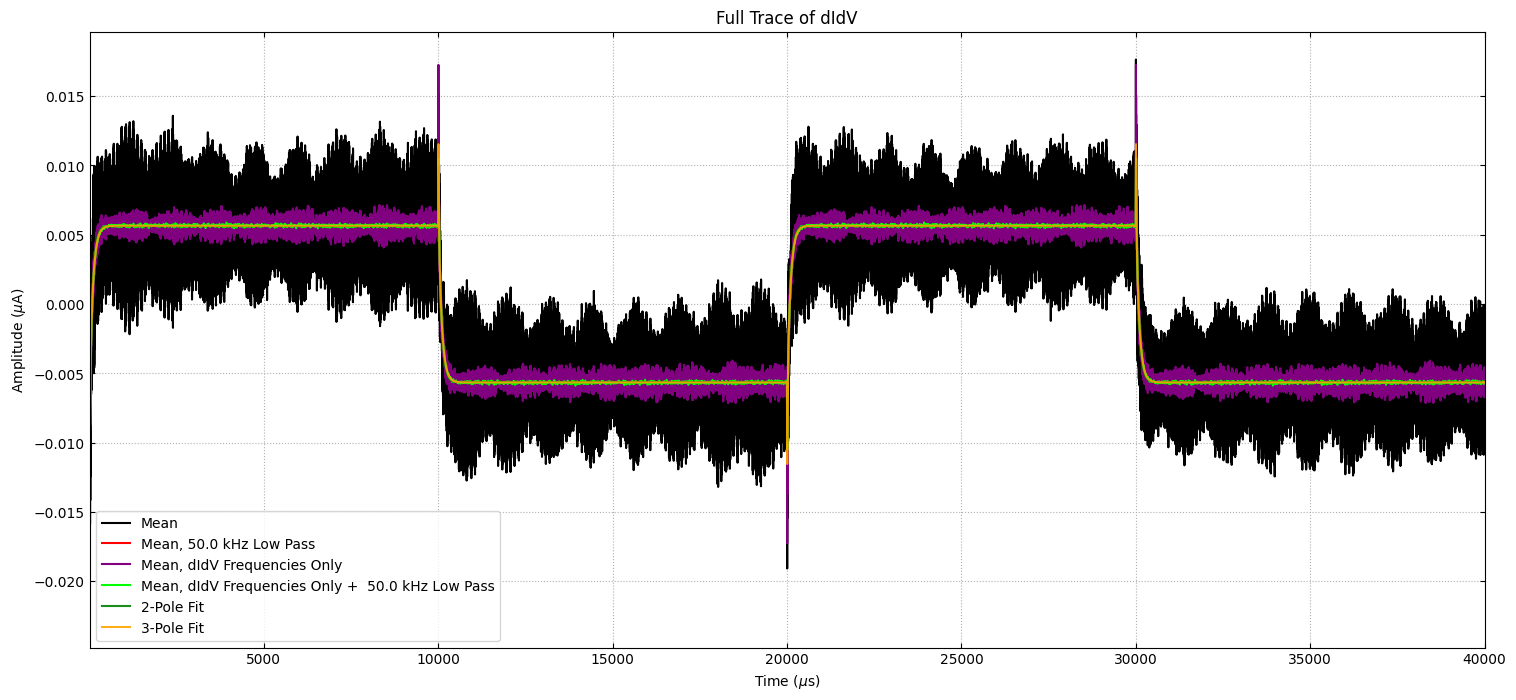

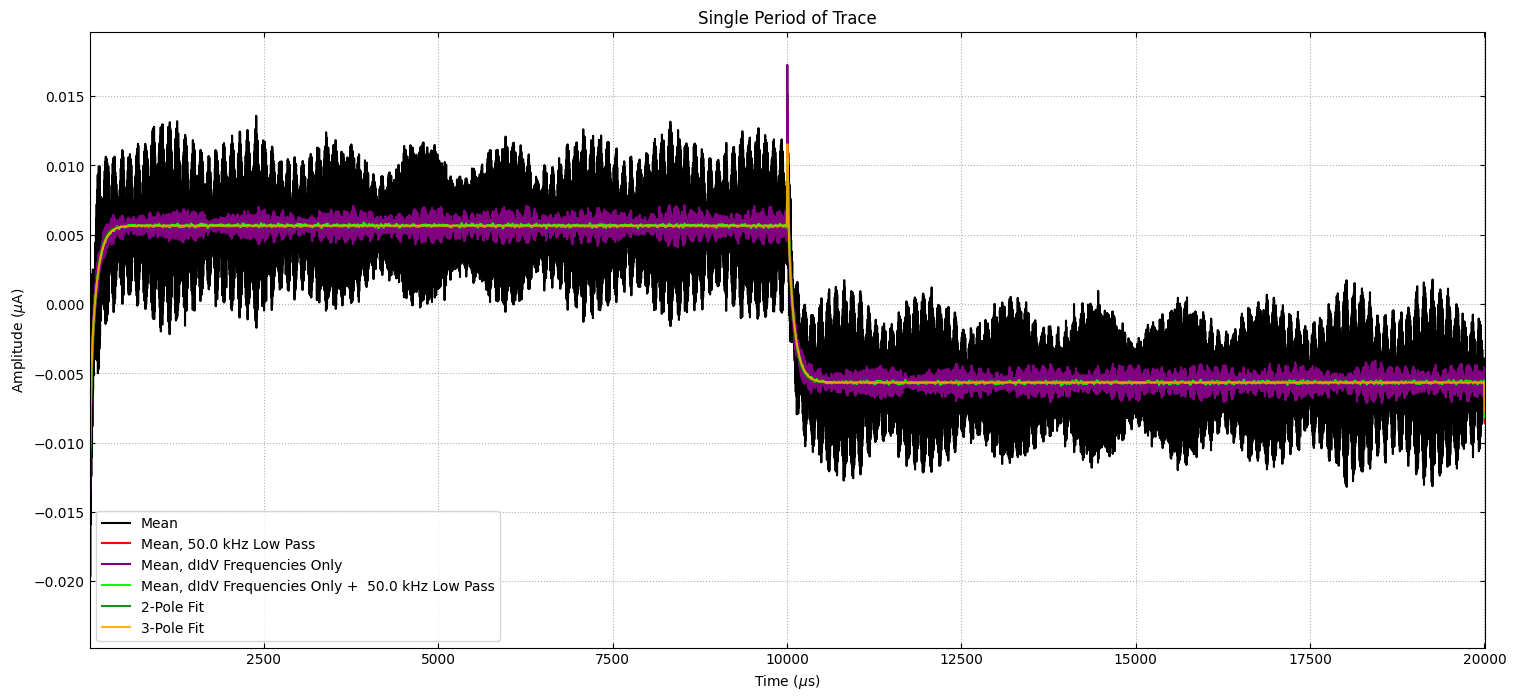

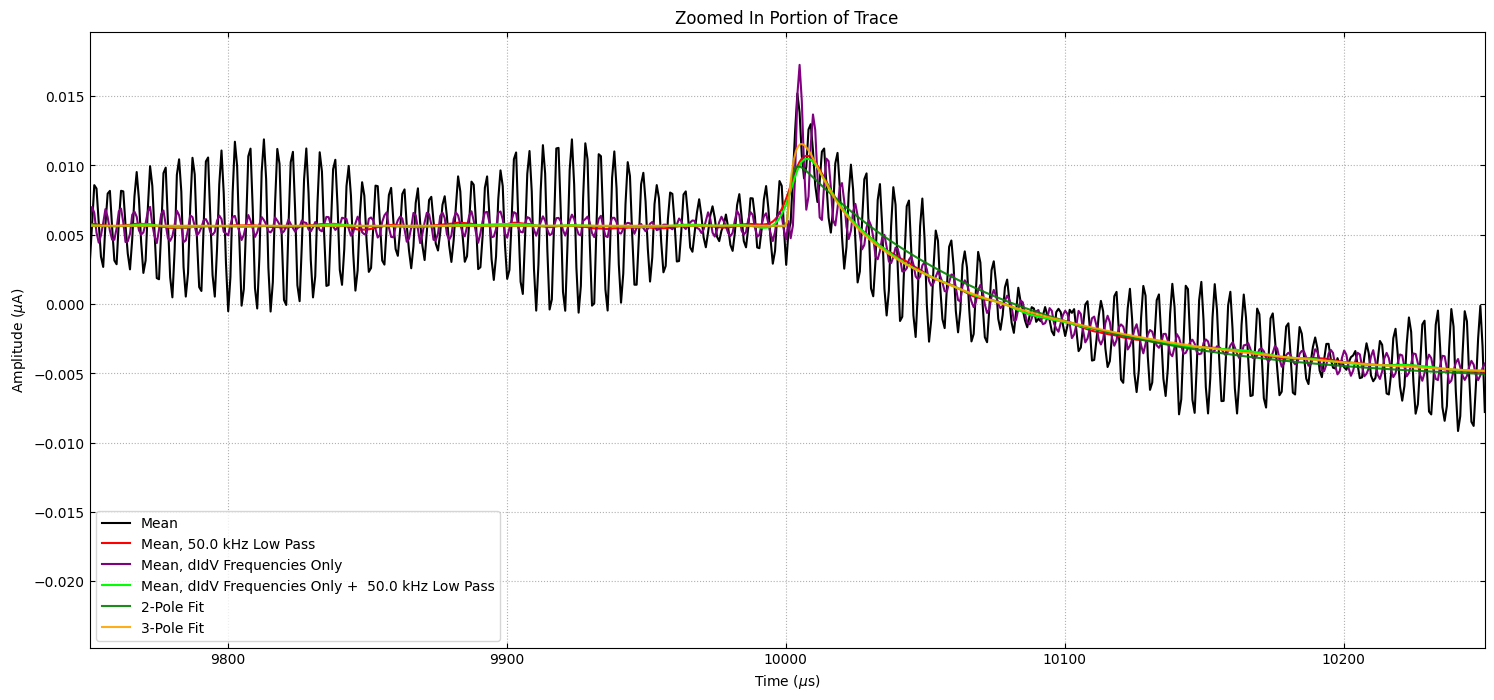

In [99]:
didvfit.plot_full_trace(didv_freq_filt = True, lp_cutoff = 50e3)
didvfit.plot_single_period_of_trace(didv_freq_filt = True, lp_cutoff = 50e3)
didvfit.plot_zoomed_in_trace(zoomfactor=0.025, didv_freq_filt = True, lp_cutoff = 50e3)

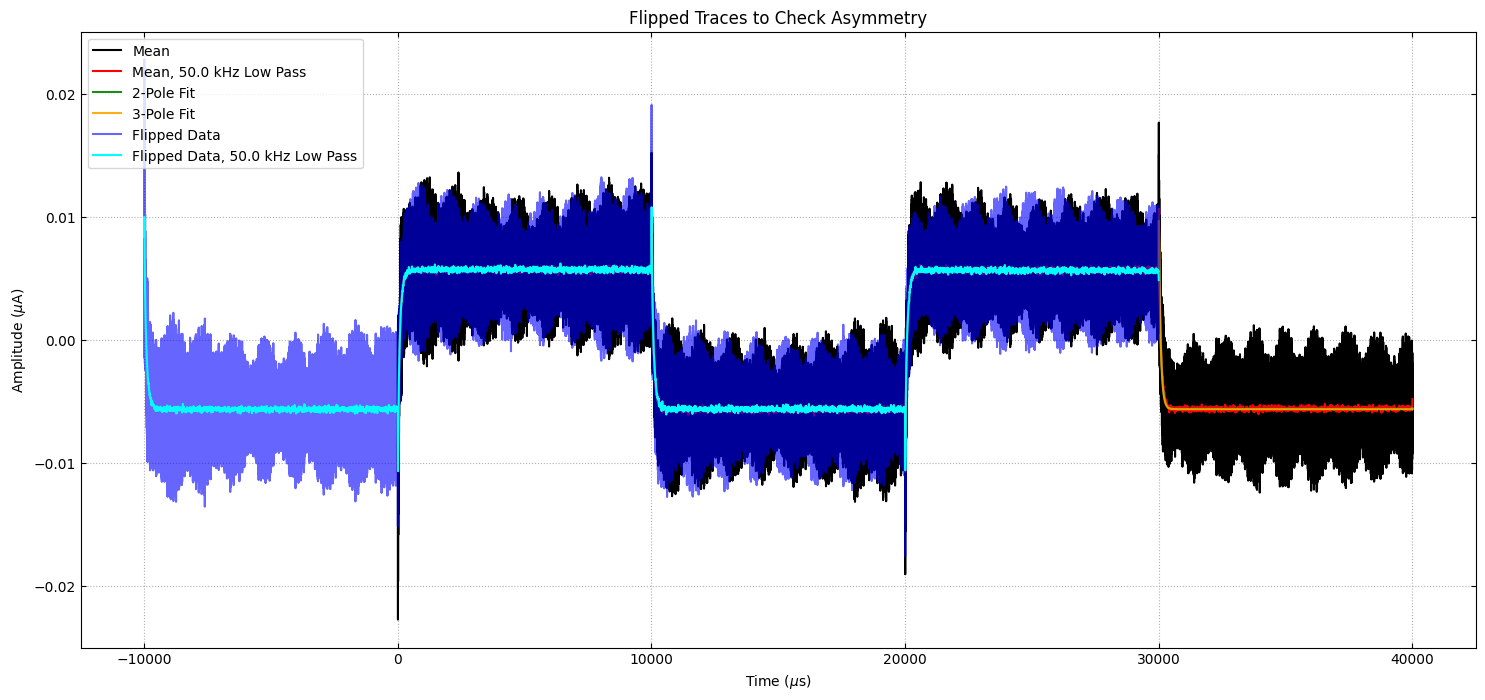

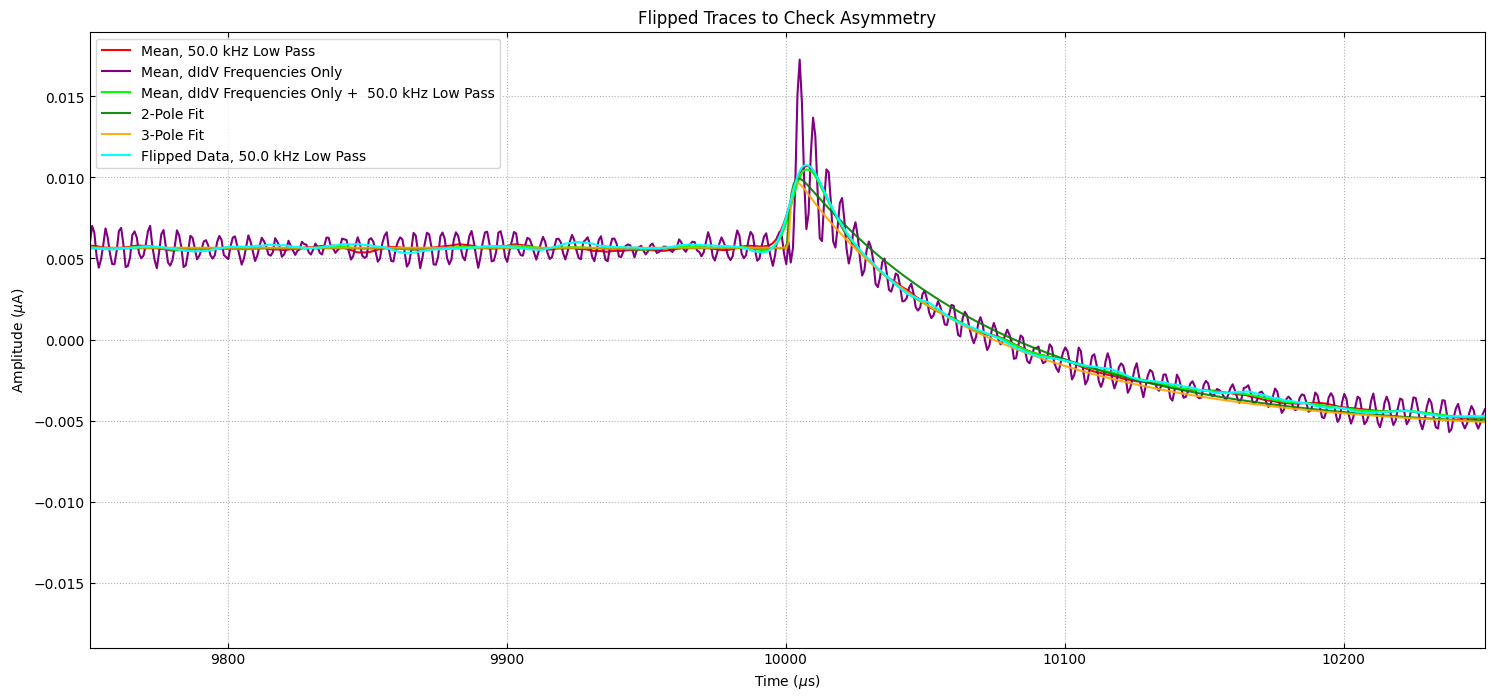

In [123]:
didvfit.plot_didv_flipped(lp_cutoff = 50e3)
didvfit.plot_didv_flipped(lp_cutoff = 50e3,poles='all', meanonly = True, zoomfactor = 0.025,didv_freq_filt=True,plotmean=False)

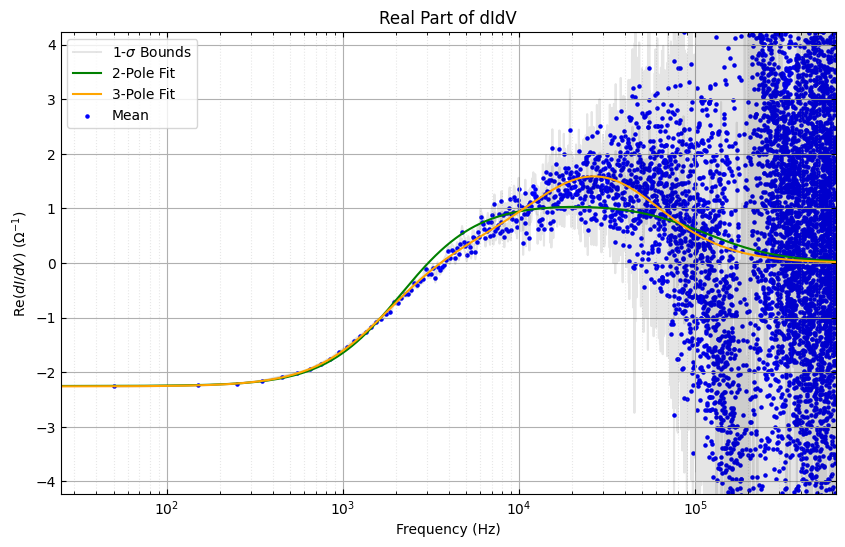

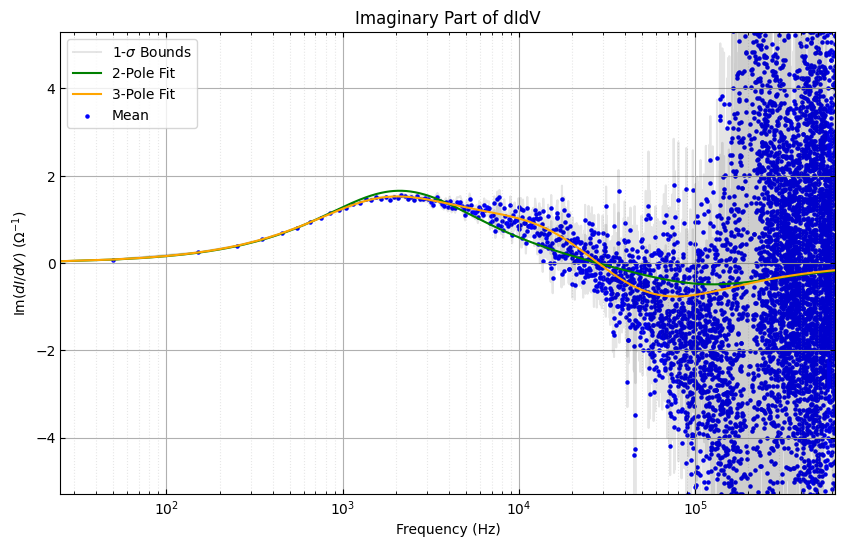

In [101]:
didvfit.plot_re_im_didv()

In [102]:
print("Fit parameters: ")
print(result['params'])
print(" ")
print("Fit covariance matrix: ")
print(result['cov'])

Fit parameters: 
{'A': 0.6546674604742636, 'B': -3.3701088733318816, 'C': -2.0718311855192555, 'tau1': -6.791957089511856e-05, 'tau2': 2.3419501600033494e-06, 'tau3': 3.6967785915789316e-05, 'dt': -4.968506772815892e-07}
 
Fit covariance matrix: 
[[ 5.25853827e-05  1.23601618e-03  1.27349781e-03  2.24956460e-08
  -2.83248714e-10  1.22952486e-09  4.15245862e-11]
 [ 1.23593129e-03  7.46637724e-02  7.14961972e-02  1.24120756e-06
  -1.31435978e-08  1.70689974e-07  2.05599940e-09]
 [ 1.27342047e-03  7.14964353e-02  6.87152419e-02  1.19394039e-06
  -1.27717363e-08  1.58949245e-07  1.98970838e-09]
 [ 2.24943183e-08  1.24121260e-06  1.19394125e-06  2.09726269e-11
  -2.16207048e-13  2.84623087e-12  3.61930703e-14]
 [-2.83236697e-10 -1.31437744e-08 -1.27718635e-08 -2.16209098e-13
   6.05850579e-15 -1.96303592e-14 -1.67836534e-15]
 [ 1.22926010e-09  1.70685703e-07  1.58944612e-07  2.84614835e-12
  -1.96292035e-14  5.40260173e-13  2.93315129e-15]
 [ 4.15225757e-11  2.05601915e-09  1.98972073e-09  

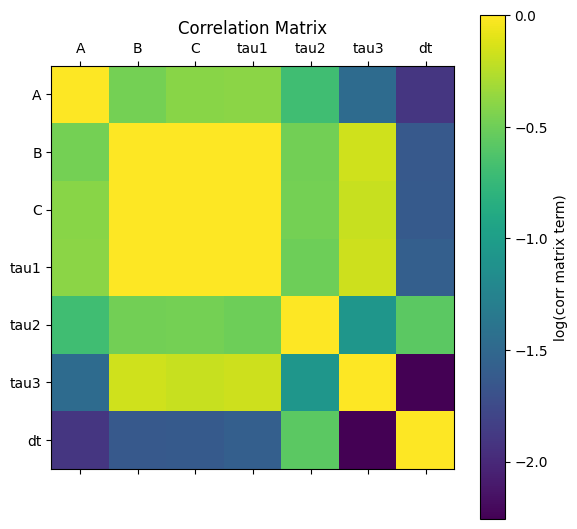

In [103]:
cov_matrix = result['cov']

#construct the correlation matrix
cor_matrix = np.zeros([7,7])

i = 0
while i < len(cov_matrix):
    j = 0
    while j < len(cov_matrix[i]):
        cor_matrix[i][j] = np.abs(cov_matrix[i][j]/(np.sqrt(cov_matrix[i][i]) * np.sqrt(cov_matrix[j][j])))
        j += 1
    i += 1
    
#plot the correlation matrix
labels = ['A', 'B', 'C', 'tau1', 'tau2', 'tau3', 'dt']
ticks = np.arange(0, 7, 1)
plt.matshow(np.log(cor_matrix))
plt.xticks(ticks=ticks, labels=labels)
plt.yticks(ticks=ticks, labels=labels)
plt.colorbar(label = "log(corr matrix term)")
plt.title("Correlation Matrix")
plt.show()

In [104]:
#bounds_right = [np.asarray([0.5, -5, -5e-3, -20e-6, 0.1e-6, 0.1e-4, -1e-9]), #small   ## small tes
#                np.asarray([1.5, -1, -1e-5, -1e-6, 4e-6, 9e-4, 9e-10])] #big
#bounds_right = np.asarray(bounds_right)
#guess_params = np.asarray([1, -2, -9e-4, -9e-6, 1e-6, 3e-4, 1e-10]) 

bounds_right = [np.asarray([0.1,   -4,   -3,   -30e-6,   0.5e-6, 0.5e-5, -1e-9]), #small      # big tes
                np.asarray([1.1,   -0.5,   3 ,   -5e-6,    4e-6,   3e-5,   9e-10])] #big
bounds_right = np.asarray(bounds_right)
guess_params = np.asarray([0.3, -0.7, -1.01, -20e-6, 2e-6, 1e-5, 1e-10])

#refit using these bounds
didvfit.dofit_with_true_current(offsets_dict, output_offset, closed_loop_norm, ibias_metadata,
                                guess=guess_params, bounds=bounds_right)
result = didvfit.fitresult(3)

In [105]:
print("Fit parameters: ")
print(result['params'])
print(" ")

Fit parameters: 
{'A': 1.0999999010608739, 'B': -1.8059449530557208, 'C': -0.17143972615677283, 'tau1': -2.9999999999999997e-05, 'tau2': 1.0089220617347404e-06, 'tau3': 2.999999999999586e-05, 'dt': 8.999999999994944e-10}
 


In [106]:
result

{'lgcfix': None,
 'params': {'A': 1.0999999010608739,
  'B': -1.8059449530557208,
  'C': -0.17143972615677283,
  'tau1': -2.9999999999999997e-05,
  'tau2': 1.0089220617347404e-06,
  'tau3': 2.999999999999586e-05,
  'dt': 8.999999999994944e-10},
 'cov': array([[ 2.50214492e-04,  7.11281214e-04,  6.51292311e-04,
          1.17456327e-08, -2.81266868e-10,  3.49337189e-08,
          4.82119480e-11],
        [ 7.11169424e-04,  7.15992237e-03,  5.18349302e-03,
          7.96345695e-08, -2.37367907e-09,  3.70193660e-07,
          4.07371365e-10],
        [ 6.51219812e-04,  5.18357791e-03,  3.85626422e-03,
          6.05580753e-08, -1.75317822e-09,  2.66571875e-07,
          3.00782038e-10],
        [ 1.17446264e-08,  7.96369561e-08,  6.05588590e-08,
          9.94331672e-13, -2.72391710e-14,  4.22759814e-12,
          5.48353069e-15],
        [-2.81232620e-10, -2.37370739e-09, -1.75317058e-09,
         -2.72386948e-14,  4.18180037e-15, -1.01436629e-13,
         -1.32596051e-15],
        [ 3.4

In [107]:
result2

{'lgcfix': None,
 'params': {'A': 1.0235420364980068,
  'B': -1.4674736147089456,
  'tau1': -3.4346050895431024e-05,
  'tau2': 1.3238843248871995e-06,
  'dt': -5.25787673719854e-07},
 'cov': array([[ 6.41233838e-05, -6.38300542e-05,  1.38317997e-09,
          1.08095829e-10, -2.16379536e-11],
        [-6.38300542e-05,  6.35774943e-05, -1.37453290e-09,
         -1.08621437e-10,  2.18438323e-11],
        [ 1.38317997e-09, -1.37453290e-09,  3.54778549e-14,
         -4.12986794e-16,  9.46683475e-16],
        [ 1.08095830e-10, -1.08621438e-10, -4.12986771e-16,
          3.77786799e-15, -1.37637671e-15],
        [-2.16379538e-11,  2.18438325e-11,  9.46683469e-16,
         -1.37637671e-15,  1.54190676e-15]]),
 'errors': {'A': 0.008007707776613781,
  'B': 0.00797354967004455,
  'tau1': 1.8835566061651352e-07,
  'tau2': 6.146436359979514e-08,
  'dt': 3.926712056274021e-08},
 'smallsignalparams': {'rsh': 0.005,
  'rp': 0.003,
  'r0': 0.182,
  'beta': 4.579901299439598,
  'l': 5.436465138444025,


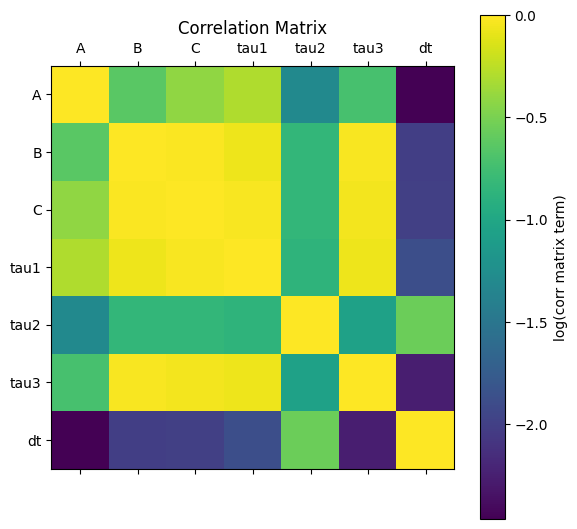

In [108]:
cov_matrix = result['cov']

#construct the correlation matrix
cor_matrix = np.zeros([7,7])

i = 0
while i < len(cov_matrix):
    j = 0
    while j < len(cov_matrix[i]):
        cor_matrix[i][j] = np.abs(cov_matrix[i][j]/(np.sqrt(cov_matrix[i][i]) * np.sqrt(cov_matrix[j][j])))
        j += 1
    i += 1
    
#plot the correlation matrix
labels = ['A', 'B', 'C', 'tau1', 'tau2', 'tau3', 'dt']
ticks = np.arange(0, 7, 1)
plt.matshow(np.log(cor_matrix))
plt.xticks(ticks=ticks, labels=labels)
plt.yticks(ticks=ticks, labels=labels)
plt.colorbar(label = "log(corr matrix term)")
plt.title("Correlation Matrix")
plt.show()

In [109]:
result2 = didvfit.fitresult(2)
print("Fit time constants, NOT dIdV Poles: ")
print("Tau1: " + str(np.abs(result2['params']['tau1'])) + ' s')
print("Tau2: " + str(result2['params']['tau2']) + ' s')
print(" ")

print("True dIdV Poles: ")
print("Tau_plus: " + str(result2['falltimes'][0]) + ' s')
print("Tau_minus: " + str(result2['falltimes'][1]) + ' s')


Fit time constants, NOT dIdV Poles: 
Tau1: 3.4346050895431024e-05 s
Tau2: 1.3238843248871995e-06 s
 
True dIdV Poles: 
Tau_plus: 1.402806284572932e-06 s
Tau_minus: 7.473409696841127e-05 s


In [110]:
print("Fit time constants, NOT dIdV Poles: ")
print("Tau1: " + str(np.abs(result['params']['tau1'])) + ' s')
print("Tau2: " + str(result['params']['tau2']) + ' s')
print("Tau3: " + str(result['params']['tau3']) + ' s')
print(" ")

print("True dIdV Poles: ")
print("Tau_plus: " + str(result['falltimes'][0]) + ' s')
print("Tau_minus: " + str(result['falltimes'][1]) + ' s')
print("Tau_third: " + str(result['falltimes'][2]) + ' s')

Fit time constants, NOT dIdV Poles: 
Tau1: 2.9999999999999997e-05 s
Tau2: 1.0089220617347404e-06 s
Tau3: 2.999999999999586e-05 s
 
True dIdV Poles: 
Tau_plus: 1.0693619596814133e-06 s
Tau_minus: 2.314953727241037e-05 s
Tau_third: 7.798870890004243e-05 s


In [111]:
print("Biasparams dict: ")
print(result['biasparams'])
print(" ")
print("i0: " + str(result['biasparams']['i0']) + " +/- " + str(result['biasparams']['i0_err']) + " amps")
print("r0: " + str(result['biasparams']['r0']) + " +/- " + str(result['biasparams']['r0_err']) + " ohms")
print("v0: " + str(result['biasparams']['v0']) + " +/- " + str(result['biasparams']['v0_err']) + " volts")
print("p0: " + str(result['biasparams']['p0']) + " +/- " + str(result['biasparams']['p0_err']) + " watts")
print(" ")
print("Bias power: " + str(result['biasparams']['p0'] * 1e15) + " fW")

Biasparams dict: 
{'i0': 2.3453706680627236e-06, 'i0_err': 7.448136776138594e-10, 'v0': 1.0279873603341598e-06, 'v0_err': 8.702193550574239e-12, 'r0': 0.43830485915613393, 'r0_err': 0.0001392408557739704, 'p0': 2.4110114020669642e-12, 'p0_err': 7.659310269818764e-16}
 
i0: 2.3453706680627236e-06 +/- 7.448136776138594e-10 amps
r0: 0.43830485915613393 +/- 0.0001392408557739704 ohms
v0: 1.0279873603341598e-06 +/- 8.702193550574239e-12 volts
p0: 2.4110114020669642e-12 +/- 7.659310269818764e-16 watts
 
Bias power: 2411.0114020669644 fW


In [112]:
print("smallsignalparameters dict:")
print(result['smallsignalparams'])
print(" ")
print(" ")

print("ssp_light dict: ")
print(result['ssp_light'])
print(" ")
print(" ")

print("Light SSP calculated values: ")
print(result['ssp_light']['vals'])
print(" ")
print("Light SSP calculated covariance matrix: ")
print(result['ssp_light']['cov'])
print(" ")
print("Light SSP uncertainties: ")
print(result['ssp_light']['sigmas'])

smallsignalparameters dict:
{'rsh': 0.005, 'rp': 0.004529920894121458, 'r0': 0.43830485915613393, 'beta': 1.4879258292190247, 'l': 6.515655417295385, 'L': 1.1098141680863473e-06, 'tau0': 0.00016546966251886153, 'gratio': 0.9456024543162412, 'tau3': 2.999999999999586e-05, 'dt': 8.999999999994944e-10}
 
 
ssp_light dict: 
{'vals': {'beta': 1.4879258292190247, 'l': 6.515655417295385, 'L': 1.1098141680863473e-06, 'tau0': 0.00016546966251886153, 'gratio': 0.9456024543162412}, 'cov': array([[ 1.30307117e-03+0.j,  4.57108204e-02+0.j, -1.29924671e-10+0.j,
         1.22351676e-06+0.j, -3.59252645e-04+0.j],
       [ 4.57057449e-02+0.j,  3.63907940e+00+0.j, -3.90197777e-08+0.j,
         9.89086604e-05+0.j, -2.95094976e-02+0.j],
       [-1.29838720e-10+0.j, -3.90172676e-08+0.j,  4.69040694e-15+0.j,
        -1.07061766e-12+0.j,  3.23408449e-10+0.j],
       [ 1.22337716e-06+0.j,  9.89085290e-05+0.j, -1.07068447e-12+0.j,
         2.68959427e-09+0.j, -8.02566623e-07+0.j],
       [-3.59210445e-04+0.j, 

In [113]:
extracted_rsh = result['smallsignalparams']['rsh']
extracted_rp = result['smallsignalparams']['rp']
extracted_rl = rp + rsh
extracted_I0 = result['biasparams']['i0']
V_b = extracted_I0*extracted_rl
print('V_b = ', V_b)

V_b =  1.876296534450179e-08


In [114]:
extracted_rp

0.004529920894121458

In [115]:
extracted_rl

0.008

In [116]:
#To calculate it more simply
print('V_b = ',extracted_rsh*209e-6)

V_b =  1.0450000000000002e-06


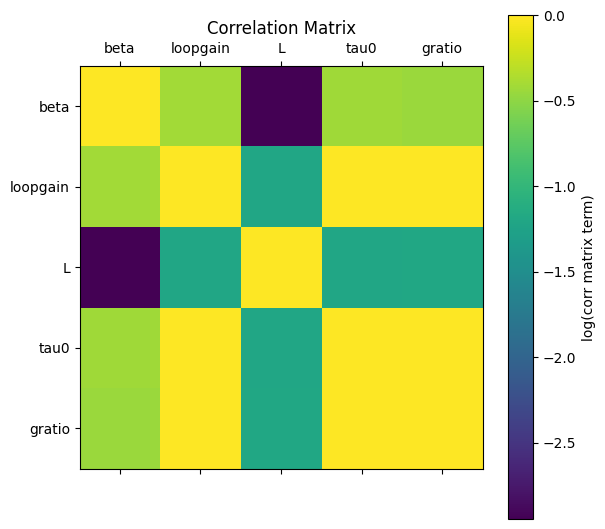

In [117]:
cov_matrix = np.abs(result['ssp_light']['cov'])
vals_vector = result['ssp_light']['vals']
cor_matrix = np.zeros([5,5])

i = 0
while i < len(cov_matrix):
    j = 0
    while j < len(cov_matrix[i]):
        cor_matrix[i][j] = cov_matrix[i][j]/(np.sqrt(cov_matrix[i][i]) * np.sqrt(cov_matrix[j][j]))
        j += 1
    i += 1

labels = ['beta', 'loopgain', 'L', 'tau0', 'gratio']
ticks = np.arange(0, 5, 1)
plt.matshow(np.log(cor_matrix))
plt.xticks(ticks=ticks, labels=labels)
plt.yticks(ticks=ticks, labels=labels)
plt.colorbar(label = "log(corr matrix term)")
plt.title("Correlation Matrix")
plt.show()

In [33]:
noise_chans = ['IrPtTESSmall','IrPtTESBig']
traces_temp, metadata = h5read.read_many_events(filepath = '/sdata1/runs/run20/raw/continuous_I2_D20220918_T165211',
    nevents=-1,
    output_format=2,
    detector_chans=noise_chans,
    include_metadata=True,
    adctoamp = True
)


KeyboardInterrupt: 

In [ ]:
Noise?

In [ ]:
IrPt_noise = Noise(traces=traces_temp,
                   fs=1.25e6, 
                   channames=noise_chans,
                   name='IrPtTES_noise')

In [ ]:
IrPt_noise.calculate_psd()
IrPt_noise.calculate_corrcoeff()
IrPt_noise.calculate_csd()
IrPt_noise.calculate_uncorr_noise()

In [ ]:
IrPt_noise.plot_psd(lgcoverlay=True)

In [ ]:
IrPt_noise.plot_corrcoeff(lgcsave=False, lgcsmooth=True, nwindow=9 )

In [ ]:
IrPt_noise.plot_csd()

In [ ]:
IrPt_noise.plot_reim_psd()

In [ ]:
IrPt_noise.plot_decorrelatednoise(lgccorrelated=True,lgcsum = True, lgcsave=False)

In [ ]:
#saveName = '/home/mwilliams/QETpy/demos/didv' + IrPt_noise.name.replace(" ", "_") + '.pkl'
#IrPt_noise.save('/home/mwilliams/QETpy/demos/didv')

In [ ]:
#with open('IrPtTES_noise.pkl','rb') as savefile:
#    IrPt_file = pickle.load(savefile)

In [ ]:
#print(IrPt_noise.__dict__)
print(IrPt_noise.corrnoise[1][0:])
print(IrPt_noise.corrnoise[0][0:])
print(IrPt_noise.corrnoise[-1][0:])

In [ ]:
#noise_path = '/sdata1/runs/run26/RQFiles/noise_continuous_I2_D20230321_T002644'

#with open(noise_path, 'rb') as handle:
#    noise_dict = pickle.load(handle)
uncorrelated_noise_current = IrPt_noise.uncorrnoise[0][1:]
correlated_noise_current = IrPt_noise.corrnoise[0][1:]
freqs = IrPt_noise.freqs[1:]
print("Loaded noise")

In [ ]:
print("Uncorrelated noise (only in TES):")
uncor_noise_power, uncor_noise_power_err, dpdi, dpdi_err = get_power_noise_with_uncertainties(freqs,
                                                                              np.sqrt(uncorrelated_noise_current), 
                                                                              result, 
                                                                              lgcplots=True, lgcdpdireturn=True)

print("----------------------")
print("Correlated noise (in phonon system):")
cor_noise_power, cor_noise_power_err, dpdi, dpdi_err = get_power_noise_with_uncertainties(freqs,
                                                                          np.sqrt(correlated_noise_current), 
                                                                          result, 
                                                                          lgcplots=True, lgcdpdireturn=True)

In [118]:
# time array, 20 ms long, at a sample fequency fs
t_arr = np.arange(0, 2e-2, 1/fs)

template_didv = get_didv_template(t_arr, 1e-2, result)


phonon_falltime = 300e-6
template_phonon = get_phonon_template(t_arr, 1e-2, result, phonon_falltime)

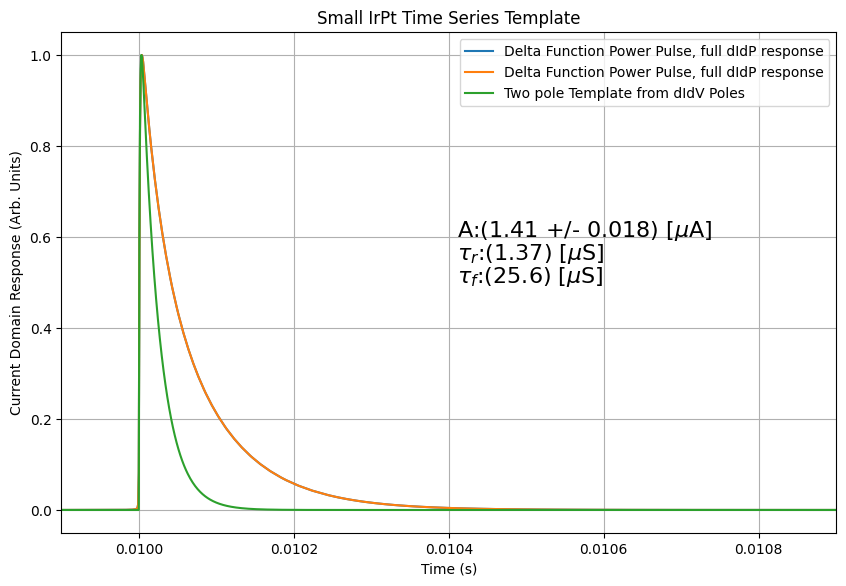

In [119]:
#For short times, we can show that this agrees with a 2 pole template calculated from the dIdV falltimes.
#At longer times, the third pole becomes important

plt.plot(t_arr, template_didv, label = "Delta Function Power Pulse, full dIdP response")
plt.plot(t_arr, template_didv, label = "Delta Function Power Pulse, full dIdP response")

tau_p = np.abs(result['falltimes'][0])
tau_m = np.abs(result['falltimes'][1])
tau_m2 = np.abs(result['falltimes'][2])

# taus from the two pole fit 
twopole_tau_p = np.abs(result2['falltimes'][0])
twopole_tau_m = np.abs(result2['falltimes'][1])

plt.plot(t_arr, make_template_twopole(t_arr, A = 1.0, t0 =1e-2, fs = 1.25e6, tau_r=tau_p, tau_f=tau_m),
        label = "Two pole Template from dIdV Poles")
#plt.plot(t_arr, make_template_threepole(t_arr, A = 1,B=1, t0 =1e-2, fs = 1.25e6, tau_r=tau_p, tau_f2=tau_m,tau_f1=tau_m2),
#        label = "Three pole Template from dIdV Poles")
#plt.plot(t_arr, template_phonon, label = "Phonon falltime, full dIdP response")

plt.title('Small IrPt Time Series Template')
plt.xlim(9.9e-3, 10.9e-3)
plt.ylabel("Current Domain Response (Arb. Units)")
plt.xlabel("Time (s)")
plt.grid()
plt.text(0.01041, 0.60, r'A:(1.41 +/- 0.018) [$\mu$A]', fontsize = 16)
#plt.text(0.01041, 0.55, r'B:(-1.80 +/- 0.018) [$\mu$A]', fontsize = 16)
plt.text(0.01041, 0.55, r'$\tau_{r}$:(1.37) [$\mu$S]', fontsize = 16)
plt.text(0.01041, 0.50, r'$\tau_{f}$:(25.6) [$\mu$S]', fontsize = 16)
plt.legend()
plt.show()

In [120]:
ofamp_to_ev = get_energy_normalization(t_arr, template_didv, result, lgc_ev=True)
ofamp_to_joules = get_energy_normalization(t_arr, template_didv, result, lgc_ev=False)

In [121]:
ofamp_to_ev

423111944.8862005

In [122]:
#Let's make some test energy norms with the various templates
twopole_ofamp_to_ev = get_energy_normalization(t_arr,  make_template_twopole(t_arr, A = 1.02, t0 =1e-2, fs = 1.25e6, tau_r=tau_p, tau_f=tau_m), result, lgc_ev=True)
print(twopole_ofamp_to_ev)

172124160.79158172


In [ ]:
#with open('IrPtTESSmall_results.pkl', 'wb') as f:
#    pickle.dump(result, f)


In [80]:
template_gen = Template(verbose=True)

In [81]:
template_gen.set_template('IrPtTESSmall', template_didv, sample_rate=1.25e6, 
                          pretrigger_length_msec=0.5)

In [82]:
template_gen.describe()


Channel IrPtTESSmall:
 * Tag "default":
    template: pandas.Series (25000,)


In [83]:
template_gen.plot_template(['IrPtTESSmall'])

In [84]:
# let's save it in am existing filter file that already has noise PSD
file_name = '/home/mwilliams/detprocess/examples/IrPt_PSDandTwoPole_from3pole_filter.hdf5'
template_gen.save_hdf5(file_name, overwrite=False)

INFO: Saving noise data to file /home/mwilliams/detprocess/examples/IrPt_PSDandTwoPole_from3pole_filter.hdf5
Storing /IrPtTESSmall/template_default in /home/mwilliams/detprocess/examples/IrPt_PSDandTwoPole_from3pole_filter.hdf5


In [85]:
template_gen.load_hdf5(file_name)
template_gen.describe()

INFO: Loading filter data from file /home/mwilliams/detprocess/examples/IrPt_PSDandTwoPole_from3pole_filter.hdf5

Channel IrPtTESSmall:
 * Tag "default":
    template: pandas.Series (25000,)
    psd: pandas.Series (25000,)
    psd_fold: pandas.Series (12501,)

Channel IrPtTESBig:
 * Tag "default":
    psd: pandas.Series (25000,)
    psd_fold: pandas.Series (12501,)
    template: pandas.Series (25000,)


In [ ]:
template_gen.plot_psd(['IrPtTESSmall','IrPtTESBig'], fold=True)

In [86]:
template_gen.plot_template(['IrPtTESSmall'])

In [ ]:
noise = Noise(verbose=True)

In [ ]:
noise.load_hdf5('./IrPt_PSDandTemplate_filter.hdf5')
noise.describe()

#### Let's read in some real data and compare to the template

In [273]:
import numpy as np
import pandas as pd
from pprint import pprint
import astropy
import vaex as vx
from matplotlib import pyplot as plt
from detanalysis import Analyzer, Semiautocut, ScatterPlotter 
import matplotlib as mpl
import qetpy
import scipy
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
import scipy.optimize as opt
from scipy.special import erf
import math

mpl.rcParams['figure.figsize'] = [10, 6.5]
from pytesdaq.io.hdf5 import H5Reader,H5Writer

import warnings
warnings.filterwarnings('ignore')

In [274]:
IrPtTESSmall = Analyzer('/sdata1/runs/run20/processed/continuous_I2_D20220918_T165211/TwoChanProc_4sig_newdidv2_feature_I2_D20230624_T110408/',series=None)


In [380]:
highsingles_BigEcut = IrPtTESSmall.df.amp_of1x1_constrained_IrPtTESSmall<2e-8 
#lowsingles_BigEcut = IrPtTESSmall.df.BigTES_Energy>0.5
highsingles_SmallEcut = IrPtTESSmall.df.amp_of1x1_constrained_IrPtTESBig <2.5e-8
lowsingles_SmallEcut = IrPtTESSmall.df.amp_of1x1_constrained_IrPtTESBig >1.5e-8
IrPtTESSmall.register_cut(highsingles_BigEcut,'SmallTES_singles',overwrite=True)
#IrPtTESSmall.register_cut(lowsingles_BigEcut,'SmallTES_singles',mode='and',overwrite=True)
IrPtTESSmall.register_cut(highsingles_SmallEcut,'SmallTES_singles',mode='and',overwrite=True)
IrPtTESSmall.register_cut(lowsingles_SmallEcut,'SmallTES_singles',mode='and',overwrite=True)

In [381]:
traces,info = IrPtTESSmall.get_traces(channels='IrPtTESSmall',raw_path='/sdata1/runs/run20/raw',cut = 'SmallTES_singles',nb_random_samples=100,trace_length_msec = 20)

INFO: Number of events found = 100


In [411]:
lowpassedtraces = []
lowpassedtraces = qetpy.utils.lowpassfilter(traces,cut_off_freq=30000,fs=fs)

In [412]:
timearr = np.linspace(0,20,25000)

In [413]:
timearr = np.linspace(0,20,25000)
pulse_amp = 1e-8 # [A]
tau_f = 23.4e-6 # [s]
tau_r = 1e-6 # [s]
pulse = np.exp(-timearr*1e-3/tau_f)-np.exp(-timearr*1e-3/tau_r)
pulse_shifted = np.roll(pulse, len(timearr)//2)
template = pulse_shifted/pulse_shifted.max()
signal = np.roll(template, 0)*pulse_amp

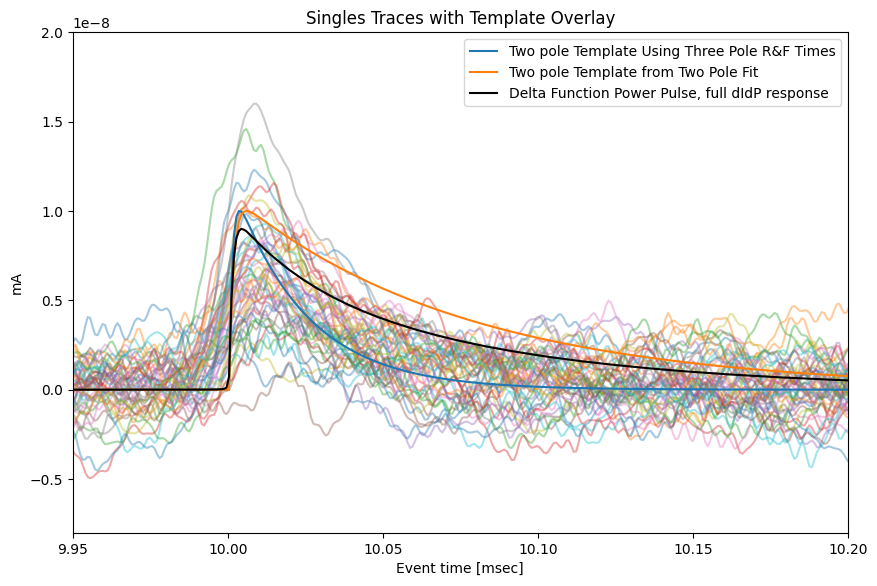

In [414]:
for xx in lowpassedtraces[0:50,0]:
    plt.plot(timearr, xx, alpha=0.4)
#plt.plot(timearr,signal,color='black',label='Template')
plt.plot(timearr, make_template_twopole(t_arr, A = 1, t0 =1e-2, fs = 1.25e6, tau_r=tau_p, tau_f=tau_m)*1e-8,
        label = "Two pole Template Using Three Pole R&F Times")
plt.plot(timearr, make_template_twopole(t_arr, A = 1, t0 =1e-2, fs = 1.25e6, tau_r=twopole_tau_p, tau_f=twopole_tau_m)*1e-8,
        label = "Two pole Template from Two Pole Fit")
plt.xlim(9.95, 10.2)
plt.ylim(-8e-9,2e-8)
plt.plot(timearr, template_didv*9e-9, label = "Delta Function Power Pulse, full dIdP response",color='black')
plt.xlabel('Event time [msec]')
plt.ylabel('mA')
plt.title('Singles Traces with Template Overlay')
plt.legend()
plt.show()